In [31]:
from feos_pcsaft.dft import ExternalPotential, PcSaftFunctional, Adsorption1D, Geometry, Pore1D, State, Pore3D, Adsorption3D, DFTSolver
from feos_pcsaft import PcSaftParameters
from feos_pcsaft.si import ANGSTROM, KELVIN, BAR, NAV, KILO, METER, MOL

import pandas as pd
import numpy as np
import os
import json
from scipy.spatial import Voronoi, distance
from itertools import permutations
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
####### class to read solid structures (Johannes) ############

class SolidStructure:

    N_atom = 0
    dimensions = {
        "Lx": 0.0,
        "Ly": 0.0,
        "Lz": 0.0
    }
    forcefield = ''
    total_mass = 0.0

    def __init__(self,structure):
 
        self.name = structure

        database = os.path.join(os.getcwd(),'structure_parameters','solid_database.json')
    
        with open(database) as f:
            data = json.load(f)

            for i in range(len(data)):
                if data[i]['Name']==self.name:
                    self.N_atom = data[i]['N_atom']
                    self.dimensions = data[i]['Dimensions']
                    self.forcefield = data[i]['Forcefield']
                    
                    
    def read_structure(self):
        struct_param = os.path.join(os.getcwd(),'structure_parameters')
        structure_df = pd.read_csv(os.path.join(struct_param,'{}.dat'.format(self.name)),names=['x','y','z','Type'], delim_whitespace=True)
        
        filename = os.path.join(struct_param,'{}.dat'.format(self.forcefield))
        forcefield_df = pd.read_csv(filename,names=['Type','sigma','epsilon','mass'], delim_whitespace=True)

        coordinates = np.array([structure_df["x"], structure_df["y"], structure_df["z"]])
        
        sigma_ss = np.zeros(len(structure_df["x"]))
        epsilon_k_ss = np.zeros_like(sigma_ss)
        
        for i in range(len(sigma_ss)):
            sigma_ss[i] = forcefield_df.sigma[forcefield_df.Type==structure_df["Type"][i]]
            epsilon_k_ss[i] = forcefield_df.epsilon[forcefield_df.Type==structure_df["Type"][i]]
        
        self.total_mass = np.sum(np.array([forcefield_df.mass[forcefield_df.Type==t]for t in structure_df.Type])) * 1.66054e-27

        return coordinates, sigma_ss, epsilon_k_ss   

In [3]:
#########  Read one example structure ########
structure = SolidStructure('LTA')
coordinates, sigma_ss, epsilon_ss = structure.read_structure()
system_size = [structure.dimensions["Lx"] * ANGSTROM, structure.dimensions["Lx"] * ANGSTROM, structure.dimensions["Lx"] * ANGSTROM]

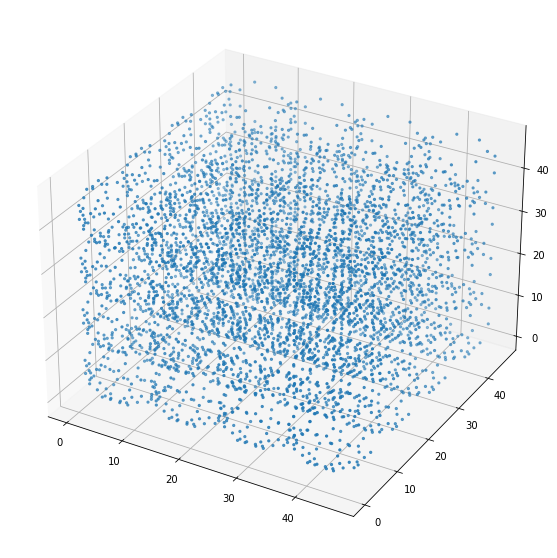

In [4]:
########## Plot example structure ##########

fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=coordinates[0,:], ys=coordinates[1,:], zs=coordinates[2,:], marker='.')
plt.show()

In [5]:
#############

In [6]:
%%time
######## Analyze example structure (determine pore radius etc) #########

vor = Voronoi(coordinates.T)

minimum_distance = 0.0
dist = np.zeros(int(vor.vertices.size / 2))
for i,point in enumerate(vor.vertices):
    if(point[0] >= 0.0 and point[0] <= structure.dimensions["Lx"] and point[1] >= 0.0 and point[1] <= structure.dimensions["Ly"]):
        dist[i] = np.min(distance.cdist(np.array([point]),coordinates.T))
pore_radius = np.max(dist)
print(pore_radius,np.argmax(dist))
pore_center = [vor.vertices[np.argmax(dist)][0], vor.vertices[np.argmax(dist)][1], vor.vertices[np.argmax(dist)][2]]
print(pore_center)

#not sure: 
n_pores= (structure.dimensions["Lx"]/(5.9595*2.0))**3
print(f"number of pores= {n_pores}")
print(f"system_size = {system_size}, pore_center = {pore_center},  pore_radius = {pore_radius}")

6.84534814234455 3220
[5.9595, 5.9594999999999985, 5.9595]
number of pores= 64.0
system_size = [4.7676 nm, 4.7676 nm, 4.7676 nm], pore_center = [5.9595, 5.9594999999999985, 5.9595],  pore_radius = 6.84534814234455
CPU times: user 531 ms, sys: 31.2 ms, total: 562 ms
Wall time: 588 ms


In [7]:
######## Read parameters and create functional #########
params = PcSaftParameters.from_json(['argon'],'structure_parameters/noble_gases.json')
func = PcSaftFunctional(params)

In [8]:
########### Create potential and initialize Pore Profile 1D ##########

potential = ExternalPotential.FreeEnergyAveraged(coordinates * ANGSTROM, sigma_ss, epsilon_ss, pore_center, system_size, [51, 51])
# pore = Pore1D(func, Geometry.Spherical, 6.84534814234455 * ANGSTROM, potential, 128)
pore = Pore1D(func, Geometry.Spherical, 5.95 * ANGSTROM, potential, 64)

In [21]:
####### Calculate isotherm 1D ########
isotherm1D = Adsorption1D.adsorption_isotherm(func, 200.0 * KELVIN, (1.0e-3 * BAR, 10.0 * BAR, 11), pore)

In [22]:
# isotherm1D.total_adsorption*NAV*64

In [23]:
# isotherm1D.adsorption*NAV*64

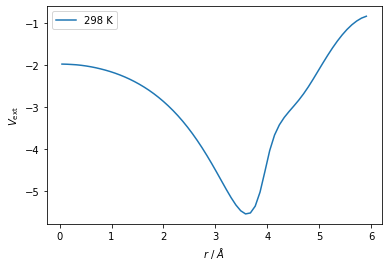

In [24]:
############ plot FEA potential #########
plt.plot(isotherm1D.profiles[0].z/ANGSTROM, isotherm1D.profiles[0].external_potential[0], label="298 K")
plt.ylabel(r'$V_{\mathrm{ext}}$')
plt.xlabel(r'$r$ / $\AA$')
plt.legend()

In [25]:
####### Initialize 3D Pore #########
pore3D = Pore3D(func, system_size, [64,64,64],coordinates* ANGSTROM, sigma_ss, epsilon_ss)

In [32]:
######## Calculate 3D isotherm ########
solver = None
### for 3D sometimes need to specify more safe solver 
# solver = DFTSolver(output=False).picard_iteration(tol=1.0e-5, beta=0.01, max_iter=20, log=False).anderson_mixing(tol=1.0e-9,mmax=10)#
isotherm3D = Adsorption3D.adsorption_isotherm(func, 200.0 * KELVIN, (1.0e-3 * BAR, 8.0 * BAR, 5), pore3D, solver=solver)

In [33]:
isotherm3D.pressure


[100.00000000000044, 200075.00000001147, 400050.00000000594, 600024.9999999956, 800000.0000000034] Pa

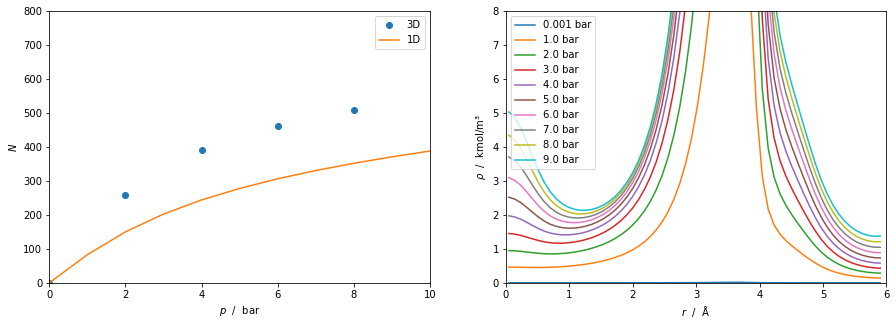

In [35]:
###### Plot 1D and 3D isotherms #########
f, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(isotherm3D.pressure/BAR, isotherm3D.total_adsorption*NAV,'o', label="3D")
ax[0].plot(isotherm1D.pressure/BAR, isotherm1D.total_adsorption*NAV*64, label="1D")
ax[0].set_xlabel('$p~~/~~\\mathrm{bar}$')
ax[0].set_ylabel('$N$')
ax[0].legend()
ax[0].set_xlim(0,10)
ax[0].set_ylim(0,800)

for profile in isotherm1D.profiles[:10]:
    ax[1].plot(profile.r/ANGSTROM, (profile.density/(KILO*MOL/METER**3)).T, label=f'{profile.bulk.pressure()/BAR:.2} bar')
ax[1].set_xlabel('$r~~/~~\\mathrm{\AA}$')
ax[1].set_ylabel('$\\rho~~/~~\\mathrm{kmol/m³}$')
ax[1].set_xlim(0,6)
ax[1].set_ylim(0,8)
ax[1].legend()

In [ ]:
## plt.plot(isotherm3D.profiles[-1].x/ANGSTROM, (isotherm3D.profiles[-1].density/(KILO*MOL/METER**3))[0,30,30,:])

In [44]:
import scipy.integrate as spin

spin.trapezoid(isotherm1D.profiles[-1].density*NAV*ANGSTROM**3 *4*3.141*(isotherm1D.profiles[-1].z/ANGSTROM) **2,isotherm1D.profiles[-1].z/ANGSTROM )*64

array([93.38036118])